In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from joblib import dump, load
from Soroosh_utilities import *
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split

In [2]:
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers


In [3]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

## The purpose of the study:

- We intent to generate synthetic test data, resembling our real-world data to increase the number of test samples for further applications.

- To this end we use, three solutions. a) Beta-VAE, b) Random Forest Regressor, c) DNN-Regressor

- Note: For more see the notion page below

https://www.notion.so/SuperOx-936b1b2ce7b14f20bd76578c82305e2b


### Initializatin for comparison of methods:

In [4]:
# reg_algs = ['RF', 'GBR-Ls', 'DNN-Reg', 'Bayes_Reg']  # Regression algorithms
# reg_results = ['MRAE', 'RMSE', 'R^2-Score',]  # 'Predictions', 'Ground Truth'
# df_reg = pd.DataFrame(index=reg_algs, columns=reg_results) 
# df_reg

In [5]:
gen_algs = ['RF', 'B-VAE', 'DNN-Reg',]  # data generation algorithm ('Bayes_Reg' if time permits)
gen_results = ['MAE', 'RMSE', ]  # 'Predictions', 'Ground Truth'
df_gen = pd.DataFrame(index=gen_algs, columns=gen_results) 
df_gen

,MAE,RMSE
RF,NaN,NaN
B-VAE,NaN,NaN
DNN-Reg,NaN,NaN


### Load dataset

In [6]:
pld_complete_zscore = pd.read_csv("/home/soroosh/SearchOX/data/pld_complete_zscore.csv", index_col=False)
pld_complete_range = pd.read_csv("/home/soroosh/SearchOX/data/pld_complete_range.csv", index_col=False)
# pld_complete = catalog.load('pld_complete').dropna().sort_values('pos', ascending=True)

In [7]:
pld_complete_range.head()

,median_Voltage_HSR_V_1025,median_Voltage_HSR_V_1027,median_Voltage_HSR_V_1030,median_Voltage_HSL_V_1025,median_Voltage_HSL_V_1027,median_Voltage_HSL_V_1030,median_Voltage_HF_V_1025,median_Voltage_HF_V_1027,median_Voltage_HF_V_1030,median_Voltage_HC_V_1025,...,std_Sigma_1030,pos,Speed,X FWHM,Y FWHM,R FWHM,Coolness,Coolness_neg,Ic,Ic_norm
0,0.129479,0.177414,0.005142,0.69562,-0.256257,-0.015406,-0.009215,-0.072807,-0.021102,0.057123,...,-0.390667,-0.501695,0.009841,0.039589,0.067470,0.015697,0.053006,-0.086369,496.2,1.767913
1,0.110059,0.340245,0.005142,0.69562,-0.321465,-0.015406,-0.009215,-0.173901,-0.021102,0.050178,...,-0.390667,-0.501652,-0.005266,0.039589,0.067470,0.015697,0.053006,-0.086369,494.7,1.762568
2,0.119769,0.340245,0.005142,0.69562,-0.321465,-0.015406,-0.007363,-0.173901,-0.021102,0.057123,...,-0.390667,-0.501646,-0.007197,0.039589,0.067470,0.015697,0.053006,-0.086369,494.2,1.760787
3,0.110059,0.348139,0.005142,0.69562,-0.322354,-0.015406,-0.009215,-0.218270,-0.021102,0.057123,...,-0.390667,-0.501635,-0.010946,0.039589,0.067470,0.015697,0.053006,-0.086369,495.5,1.765419
4,0.110059,0.264593,0.005142,0.69562,-0.305820,-0.015406,-0.009215,-0.129533,-0.021102,0.057123,...,-0.390667,-0.501619,-0.017147,0.042682,0.069442,0.017956,0.051965,-0.084836,497.9,1.773168


In [8]:
# We need to generate whole data set including the target values, thus: 
x_z = pld_complete_zscore.to_numpy()  # .loc[:, ~pld_complete_zscore.columns.isin(['Ic', 'Ic_norm', 'pos'])].to_numpy()

x_r = pld_complete_range.to_numpy()  # .loc[:, ~pld_complete_range.columns.isin(['Ic', 'Ic_norm', 'pos'])].to_numpy()

# for future possible usage
y_ic = pld_complete_range['Ic'].to_numpy()
y_ic_norm = pld_complete_range['Ic_norm'].to_numpy()
pos = pld_complete_range['pos'].to_numpy()

x_z.shape, x_r.shape, y_ic.shape, y_ic_norm.shape, pos.shape

((18561, 385), (18561, 379), (18561,), (18561,), (18561,))

In [9]:
assert not np.any(np.isnan(x_r))

In [10]:
x_r_train, x_r_test, y_train, y_test = train_test_split(x_r, y_ic,
                                                        test_size=0.40,
                                                        random_state=43,)

x_r_val, x_r_test, y_val, y_test = train_test_split(x_r_test, y_test,
                                                        test_size=0.5,
                                                        random_state=43,)


x_r_train.shape, x_r_test.shape, x_r_val.shape, y_train.shape, y_test.shape, y_val.shape

((11136, 379), (3713, 379), (3712, 379), (11136,), (3713,), (3712,))

### $\beta$-VAE

ELBO objective function: $- \mathcal{L}(\theta, \phi; x^{i}) = \beta . D_{KL} (q_{\phi} (z| x^{i}) || p_{\theta}(z)) + \mathbb{E}_{q_{\phi} (z| x^{i}} [- \log p_{theta}(x^{i}|z)]$

We denote the weight of KL-Divergence in the ELBo loss function with $\beta$. 
If $\beta=1$ the ordinary VAE will be obtained

In [11]:
input_shape = (x_r.shape[1])  
encoded_size = 16  # [16, 64, 128, 256]
n_units = 128
kl_weight = 1  # Beta in ELBO

#### The choice of encoded_size:

By fixing the number of units=128, kl_weight=1, and n_epochs=50 
we examined the above list of sizes, and we choose the one which gives us the minimum RMSE error.

Once we found the better number of encoded_size, we repeat the experiments with all fixed parameters and increase the number of epochs to 500 and use the early_stop method.

- The reason for fixing n_epochs to 50 is the issue of time. 



we obtained the following results for different encoded_size

    - encoded_size = 16: MAE = 1.78102 ; RMSE = 25.1806

    - encoded_size = 64: MAE = 2.53542 ; RMSE = 25.3327

    - encoded_size = 128: MAE = 2.08475  ; RMSE = 25.3549

    - encoded_size = 256: MAE = 1.83895  ; RMSE = 24.9845

- We cannot make a specific conclusion. Surprisingly, both of the largest and the smallest encoded_size return similar and smaller MAE than the other two. While the smallest encoded_size is far faster. So we've chosen 16.



In [12]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [13]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32)),  # Wraps arbitrary expressions as a Layer object
    tfkl.Dense(2*n_units, activation=tf.nn.leaky_relu),
    tfkl.Dense(n_units, activation=tf.nn.leaky_relu),
    tfkl.Dense(int(.5*n_units), activation=tf.nn.leaky_relu),
    tfkl.Dense(encoded_size, activation=tf.nn.leaky_relu),
    tfkl.Flatten(),  # Flattens the input. Does not affect the batch size (can be ignored in our case, though)
    # a stochastic encoder
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),  # Wrapping MVN Normal dist as a layer with n_units = encode_size
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=kl_weight)),  # reparametrization trick  
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [14]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, encoded_size]),  # can be ignored in our case.
    tfkl.Dense(encoded_size, activation=tf.nn.leaky_relu),
    tfkl.Dense(n_units, activation=tf.nn.leaky_relu),
    tfkl.Dense(2*n_units, activation=tf.nn.leaky_relu),    
    # a stochastic decoder
    tfkl.Dense(tfpl.IndependentNormal.params_size(input_shape)),  
    tfkl.Flatten(),
    tfpl.IndependentNormal(input_shape, ),  
])

In [15]:
n_epochs = 3000  # previously, it was 500
learning_rate = 1e-5  # [1e-2, 1e-3, 1e-5] 
batch_size = 64  # [32, 64, 256]

#### Choosing the appropriate learning (LR) rate and batch_size (BS) :

By fixing the number of epochs to 10, we examined the different combinations of LR and BS.
We have chosen those values at which the training and validation loss plots are smoother than the other.


##### Number of epochs:

By fixing the number of epochs to 500/1000. ( using the early_stop method to avoid overfitting, did not yield a goad model)





**babysitting the parameters:**

- 32, 1e-2: loss is nan

- 32, 1e-3: loss from 851.0405 to 192.3584 (relatively nice and smooth)

- 32, 1e-5: loss from 29690.0409 to 9637.8109 (nice and smooth)  *

- 64, 1e-2: loss is nan

- 64, 1e-3: loss from 79237.0616 to 227.4151 (relatively nice and smooth)

- 64, 1e-5: loss from 601726.3477 to 47216.5597 (nice and smooth with one pick at epoch 4) **

- 256, 1e-2: loss from 13167108275131.7324 to nan 

- 256, 1e-3: loss from 323651799945489.0625 to 54396.1562 (sudden drop)

- 256, 1e-5: loss from  120421062.9333 to 4795335.4667 (nice and smooth) *** 


We have chosen the setting marked by ** (64, 1e-5)




In [16]:
beta_vae = tfk.Model(inputs=encoder.inputs,
                    outputs=decoder(encoder.outputs[0]))

In [ ]:
%%time 
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)  # for early-stop

beta_vae.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                 loss=negloglik, 
                )

history = beta_vae.fit(x=x_r_train, y=x_r_train,
                       epochs=n_epochs, batch_size=batch_size,
                       validation_data=(x_r_val, x_r_val),
#                        callbacks=[callback],  # for early stop
                      )

Epoch 1/3000
Cause: could not parse the source code of <function <lambda> at 0x7f57d81a39e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f57d81a39e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
174/174 [==============================] - 2s 5ms/step - loss: 118113014443571.2031 - val_loss: 801977597952.0000
Epoch 2/3000
174/174 [==============================] - 1s 3ms/step - loss: 81450476731.8857 - val_loss: 465981702144.0000
Epoch 3/3000
174/174 [==============================] - 1s 3ms/step - loss: 687237131901.8057 - val_loss: 8700210176.0000
Epoch 4/3000
174/174 [==============================] - 1s 3ms/step - loss: 546564848516.8422 - val_loss: 4773753913344.0000
Epoch 5/3000
174/174 [==============================] - 1s 3ms/step - loss: 160698709833.9886 - val_loss: 815

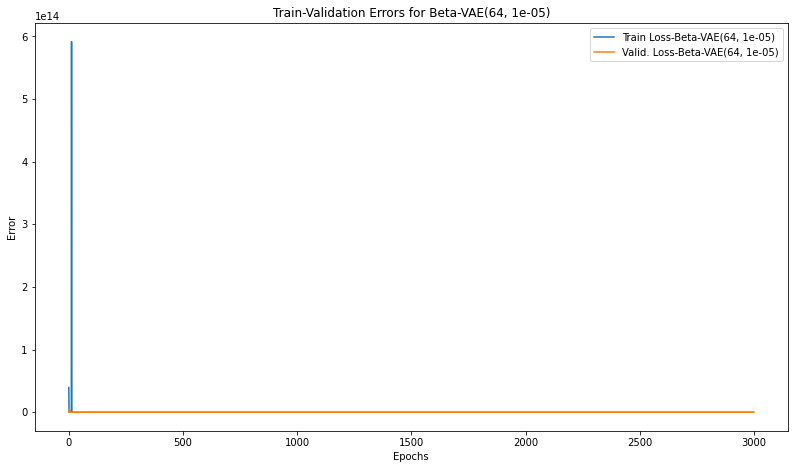

In [40]:
plot_loss(history=history, name='Beta-VAE('+ 
          str(batch_size)+ ", " + str(learning_rate)+ ')')

In [41]:
# We'll just examine ten random digits.
n_samples = 20
rnd_samples = np.random.randint(0, x_r_test.shape[0], size=n_samples)
x = x_r_test[rnd_samples]
xhat = beta_vae(x)
assert isinstance(xhat, tfd.Distribution)

In [42]:
x.shape

(20, 379)

In [43]:
# y_ic_hat = xhat.sample()[:n_samples, -1]
# y_ic_true = x_r_test[:n_samples, -1]
# y_ic_hat.shape, y_ic_true.shape
# plot_predictions(y_test=y_ic_true, y_pred=y_ic_hat, name='Beta-VAE')

#### plotting the original and reconstructed samples
This is an aggregated plots of all features. 

It is noteworthy to add that, this is not a very trustable resource of evaluation, still, it is intuitive source of information on how the trained model works.

Originals:


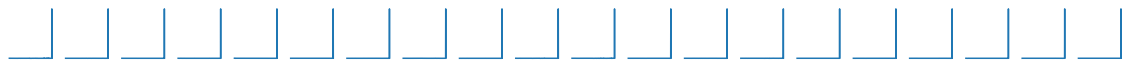

Decoded Random Samples:


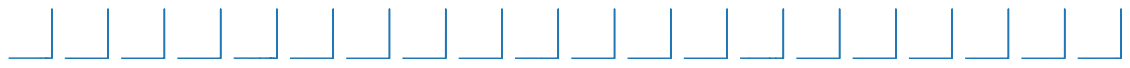

Decoded Modes:


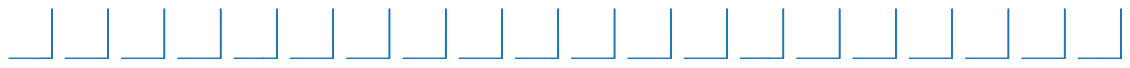

Decoded Means:


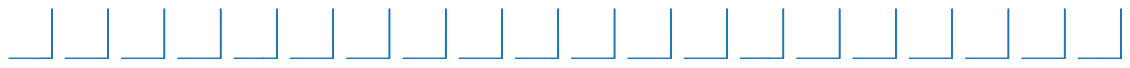

In [44]:
print('Originals:')
display_samples(x)

print('Decoded Random Samples:')
display_samples(xhat.sample())

print('Decoded Modes:')
display_samples(xhat.mode())

print('Decoded Means:')
display_samples(xhat.mean())

##### Now, let's generate ten never-before-seen samples.

In [45]:
z = prior.sample(n_samples)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)

Randomly Generated Samples:


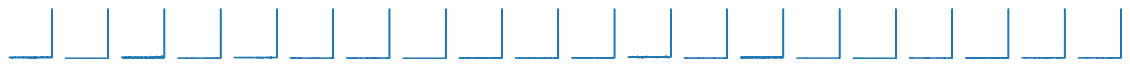

Randomly Generated Modes:


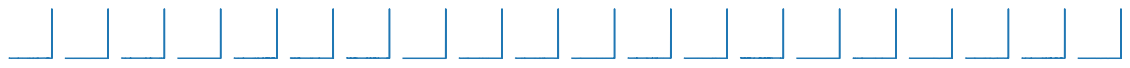

Randomly Generated Means:


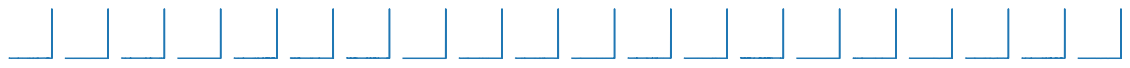

In [46]:
print('Randomly Generated Samples:')
display_samples(xtilde.sample())

print('Randomly Generated Modes:')
display_samples(xtilde.mode())

print('Randomly Generated Means:')
display_samples(xtilde.mean())

In [47]:
x_hat_bvae = beta_vae(x_r_test).sample().numpy()


In [48]:
x_hat_bvae.shape

(3713, 379)

In [50]:
df_gen = add_to_data_generation_comparison(df_gen,
                                           y_preds=x_hat_bvae,
                                           y_trues=x_r_test, 
                                           name='B-VAE')
df_gen

,MAE,RMSE
RF,0.040969,0.0783567
B-VAE,0.214494,3.86635
DNN-Reg,0.0365083,0.0550026


- The B-VAE result is for the case when early-stop method is not applied.


In [ ]:
# Saving the trained weights for future applications
# !mkdir -p saved_model
# beta_vae.save_weights('saved_model/beta_vae-3k.h5')


In [ ]:
# # Create a new model instance

# # Load the previously saved weights
# # beta_vae = tfk.Model(inputs=encoder.inputs,
# #                     outputs=decoder(encoder.outputs[0]))

# Note the name of the saved weights from the above cell
# beta_vae.load_weights('saved_model/beta_vae.h5') 

# y_preds_saved_model = beta_vae(x_r_test).sample().numpy()

# df_gen = add_to_data_generation_comparison(df_gen,
#                                            y_preds=y_preds_saved_model,
#                                            y_trues=x_r_test, 
#                                            name='B-VAE')
# df_gen

## Genereting the data with RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor


#### RF Reg hyperparameters:

Among all 17 possible hyperparameters of RF-Reg we studied the following because, at least, the rest have determinstic solution to decide the default value. (Moreover, studying all of them would be indeed time-consuming).

- n_estimatorsint, default=100. The number of trees in the forest.  # we examine: [100, 300]

- min_samples_leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.  # [1, 3, ]

- n_estimator: 100, min_samples_leaf=1:  MRE = 0.0409 ; RMSE = 0.0783

- n_estimator: 100, min_samples_leaf=3:  MRE = 0.0445 ; RMSE = 0.0832

- n_estimator: 300, min_samples_leaf=1:  MRE = 0.0407 ; RMSE = 0.0779

- n_estimator: 300, min_samples_leaf=3:  MRE = 0.0444 ; RMSE = 0.0831


As we can see increasing the number of estimators or min_samples_leaf, has not much important impacts on the performance of algorithm. However, the larger either of them, the longer the execution time and the model. So we will use the minimal parameters.


In [ ]:
train = False 

if train:
    # For training RF with different parameters:
    %%time
    n_estimators = [100]  # 300 
    min_samples_leaf = [1]  # 3

    for i in n_estimators:
        for j in min_samples_leaf:

            rf_reg = RandomForestRegressor(n_estimators=i, 
                                   n_jobs = 3, 
                                   criterion='mse', 
                                   min_samples_leaf=j,
                                   verbose=1)

            rf_reg.fit(x_r_train, x_r_train)

            x_hat_rf = rf_reg.predict(x_r_test)
            filename = "rf_reg-" + str(i) + '-' +str(j) + ".joblib"
            dump(rf_reg, "saved_model/"+ filename )

            print("i=", i, "j=", j )
            print(mae(y_preds=x_hat_rf, y_trues=x_r_test))
            print(rmse(y_preds=x_hat_rf, y_trues=x_r_test))
            print(" ")

In [51]:
# For loading the trained and saved model: 

n_estimators = [100]
min_samples_leaf = [1, ]  # , 3
for i in n_estimators:
    for j in min_samples_leaf:
        filename = "rf_reg-" + str(i) + '-' +str(j) + ".joblib"
        rf_reg_ = load("saved_model/"+ filename)
        x_hat_rf = rf_reg_.predict(x_r_test)
        
        print("i=", i, "j=", j )
        print(mae(y_preds=x_hat_rf, y_trues=x_r_test))
        print(rmse(y_preds=x_hat_rf, y_trues=x_r_test))
        print(" ")

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s


i= 100 j= 1
0.040969015546428594
0.07835667381014835
 


[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.3s finished


Originals:


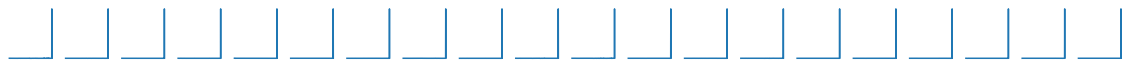

Decoded Random Samples:


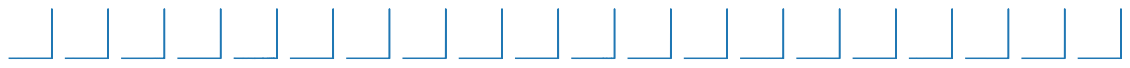

In [52]:
print('Originals:')
display_samples(x_r_test[rnd_samples])

print('Decoded Random Samples:')
display_samples(x_hat_rf[rnd_samples])

In [53]:
df_gen = add_to_data_generation_comparison(df_gen,
                                           y_preds=x_hat_rf,
                                           y_trues=x_r_test, 
                                           name='RF')
df_gen

,MAE,RMSE
RF,0.040969,0.0783567
B-VAE,0.214494,3.86635
DNN-Reg,0.0365083,0.0550026


## DNN-Regressor



In [ ]:
class DnnReg(tfk.Model):
    
    def __init__(self, n_units, n_features, name='dnn_reg', **kwargs):
        super(DnnReg, self).__init__(name=name, **kwargs)
        self.n_units = n_units
        self.n_features = n_features
        
        self.input_layer = tfkl.InputLayer(input_shape=self.n_features)
        self.cast_layer = tfkl.Lambda(lambda x: tf.cast(x, tf.float32))
        self.dense_1 = tfkl.Dense(units=int(.5*self.n_units), activation=tf.nn.leaky_relu)
        self.dense_2 = tfkl.Dense(units=self.n_units, activation=tf.nn.leaky_relu)
        self.dense_3 = tfkl.Dense(units=2*self.n_units, activation=tf.nn.leaky_relu,)
        self.regressor = tfkl.Dense(units=self.n_features)
        
    def call(self, inputs):
        x = self.input_layer(inputs)
        x = self.cast_layer(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        regression = self.regressor(x)
        return regression
        
        

In [ ]:
dnn_reg = DnnReg(n_units=n_units, n_features=input_shape)



In [ ]:

callback = tfk.callbacks.EarlyStopping(monitor='loss', patience=5)  # for early-stop

dnn_reg.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                loss='mse',
               )

history_dnn_ref = dnn_reg.fit(x=x_r_train, y=x_r_train,
           epochs=n_epochs, batch_size=batch_size,
           validation_data=(x_r_val, x_r_val),
#            callbacks=[callback],
           )

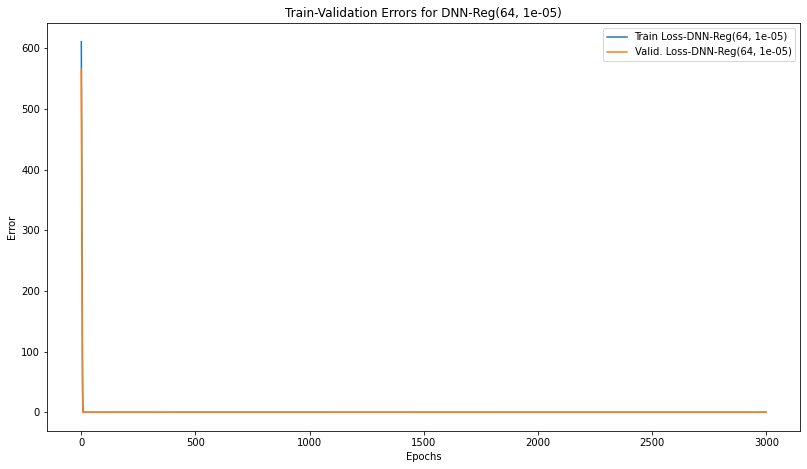

In [56]:
plot_loss(history=history_dnn_ref, name='DNN-Reg('+ 
          str(batch_size)+ ", " + str(learning_rate)+ ')')

In [61]:
# Saving the trained weights for future applications
# !mkdir -p saved_model
# dnn_reg.save_weights('saved_model/dnn_reg-3k.h5')



In [63]:
x_hat_dnn_reg = dnn_reg.predict(x_r_test)
x_hat_dnn_reg.shape

(3713, 379)

Originals:


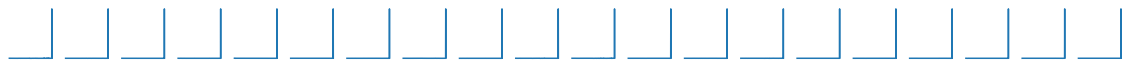

Decoded Random Samples:


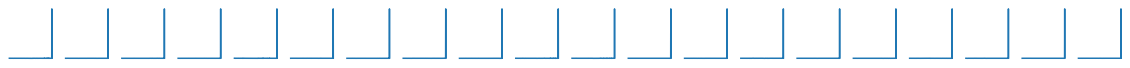

In [58]:
print('Originals:')
display_samples(x_r_test[rnd_samples])

print('Decoded Random Samples:')
display_samples(x_hat_dnn_reg[rnd_samples])

In [62]:
df_gen = add_to_data_generation_comparison(df_gen,
                                           y_preds=x_hat_dnn_reg,
                                           y_trues=x_r_test, 
                                           name='DNN-Reg')
df_gen

,MAE,RMSE
RF,0.040969,0.0783567
B-VAE,0.214494,3.86635
DNN-Reg,0.0365083,0.0550026


## Conclusion

- As we can we both of RF and DNN-Reg brings ver good results. 

- By increasing the number of epochs from 1.5k. to 3k, we managed to improve the B-VAE results (to the current values). 

- However, since the obtained results of RF and DNN-Reg is quite acceptable, we withdraw the B-VAE (at this moment, due to its week results.)

-  As the next step we are going to use DNN-Reg model to generate 18k mor samples and will proceed with the rest of the tasks.

### Generate and save synthetic data

In [82]:
x_r_synthetic = dnn_reg.predict(x_r)

np.savetxt("x_r_synthetic.npy", x_r_synthetic)
x_r_synthetic.shape

(18561, 379)

In [85]:
tmp = np.loadtxt("x_r_synthetic.npy")
tmp.shape 

(18561, 379)

In [86]:
tmp.all() == x_r_synthetic.all()

True